In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy
from tvb.simulator.lab import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/duke/src/tvb-root/tvb_library/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


# setup delays inside mass model

In some cases, the neural mass model needs its own state variables at a small time delay, which (currently) requires light customization of the history and simulator classes:

- history class which tracks which time step & dt
- simulator class using custom history class & provides model instance a reference to history
- model class which makes use of history

here the custom history & simulator are generic and can be re-used, but the model example is contrived.

In [26]:
from tvb.simulator.history import SparseHistory

class MyHistory(SparseHistory):
    dt = None
    step = -1
    def query_sparse(self, step):
        self.step = step
        return super().query_sparse(step)
    def get_delayed_state(self, tau):
        tau_steps = int(tau / self.dt)
        assert tau_steps < self.n_time  # cannot look back past max delay
        return self.buffer[ (self.step - 1 - tau_steps) % self.n_time ]

class MySim(simulator.Simulator):
    def configure(self):
        super().configure()
        self.model.history = self.history
        self.history.dt = self.integrator.dt
        return self
    def _configure_history(self, initial_conditions=None):
        self.history = MyHistory.from_simulator(self, initial_conditions)

# XXX this part is contrived, requires modeler to choose
class MyModel(models.MontbrioPazoRoxin):
    def dfun(self, rV, crV, lc):
        # create 10 ms delayed feedback
        rV_tau = self.history.get_delayed_state(tau=10.0) * -1
        #  from local V to the local r
        crV[0] = rV_tau[1]
        # do the rest with the standard MPR implementation
        return super().dfun(rV, crV, lc)

2025-03-18 22:12:03,703 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


Text(0.5, 1.0, 'Temporal Average')

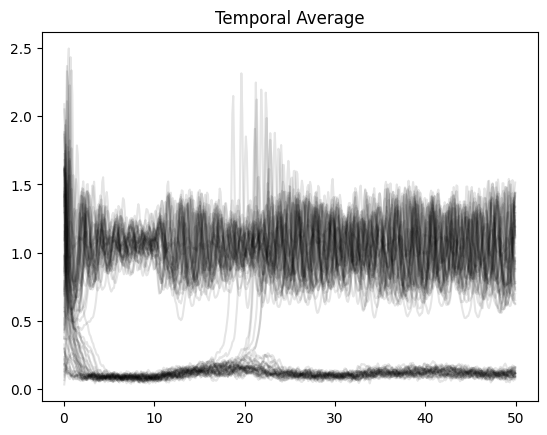

In [102]:
# XXX use customized simualtor class, but everything else is typical tvb
sim = MySim(
    model=MyModel(),
    connectivity=connectivity.Connectivity.from_file(),
    coupling=coupling.Linear(a=numpy.array([1e-2])),
    integrator=integrators.HeunStochastic(dt=0.01, noise=noise.Additive(nsig=np.r_[0.001])),
    monitors=(monitors.TemporalAverage(period=0.1),),
    simulation_length=5e1,
)
sim.history
sim = sim.configure()

# run it
(time, data), = sim.run()

# visualize time series
plt.figure()
plt.plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
plt.title("Temporal Average")

here we see some amplitude modulation due entirely to the local time-delayed feedback, which is not present in the original MPR model.